In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

from astropy.io import fits
from scipy.signal import find_peaks
from scipy.signal import resample

from rascal.calibrator import Calibrator
from rascal.util import refine_peaks

/usr/local/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



In [2]:
data = fits.open('examples/isis_pso1801p6254_g93m48_raw/r2701247.fit.gz')[1]

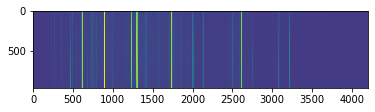

In [3]:
plt.imshow(np.log(data.data.T))

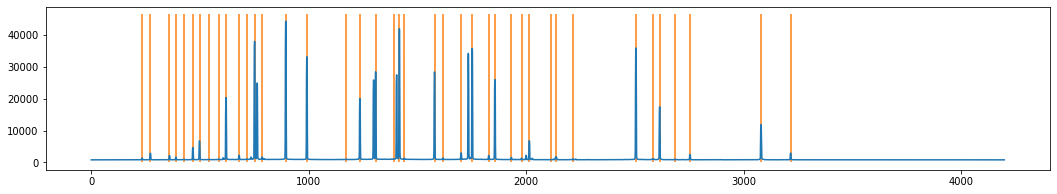

In [4]:
spectrum = np.median(data.data.T, axis=0)

peaks, _ = find_peaks(spectrum, prominence=80, distance=20, threshold=None)

peaks_refined = refine_peaks(spectrum, peaks, window_width=3)
plt.figure(figsize=(18,3))
plt.plot(spectrum)
plt.vlines(peaks_refined,
              0,
              1.05*spectrum.max(),
              colors='C1')

In [5]:
c = Calibrator(peaks_refined, elements=["CuNeAr_low"],
               min_wavelength=7000.,
               max_wavelength=10500.,
               range_tolerance=500)
c.set_fit_constraints(n_pix=len(spectrum), ransac_thresh=1, polydeg=5)

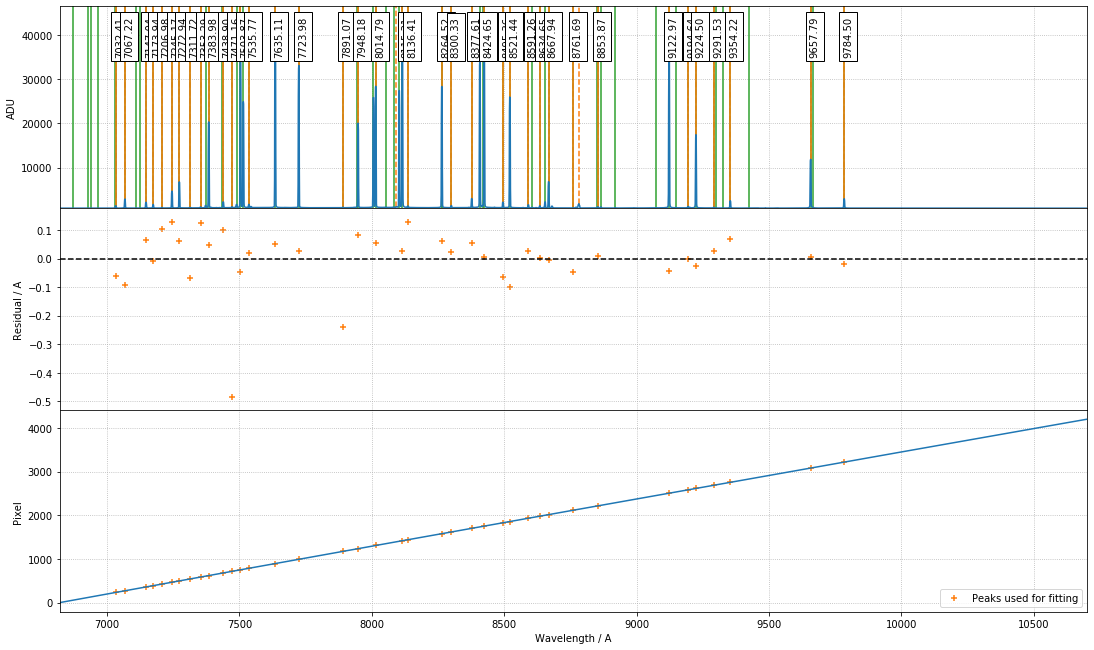

Stdev error: 0.1059021844231794 A


In [6]:
best_p = c.fit(max_tries=2000)
best_p, x_fit, y_fit = c.match_peaks_to_atlas(best_p, tolerance=1)
best_p, x_fit, y_fit = c.match_peaks_to_atlas(best_p, tolerance=0.5)

c.plot_fit(spectrum, best_p, plot_atlas=True, log_spectrum=False, tolerance=0.5)

fit_diff = c.polyval(best_p,x_fit)-y_fit

rms = np.sqrt(np.sum(fit_diff**2/len(x_fit)))

print("Stdev error: {} A".format(fit_diff.std()))